In [1216]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import linear_reset
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Задание 1
___

__`Y`__ - потребление цыплят

__`X1`__ - среднедушевой доход

__`X2`__ - стоимость одного фунта цыплят

__`X3`__ - стоимость одного фунта свинины 

__`X4`__ - стоимость одного фунта говядины 

In [1217]:
data = pd.read_excel('задание1.xlsx', index_col=0)

data.head()

,Y,X1,X2,X3,X4
t,,,,,
1,31.2,492.9,37.3,54.7,77.4
2,33.3,528.6,38.1,63.7,80.2
3,35.6,560.3,39.3,69.8,80.4
4,36.4,624.6,37.8,65.9,83.9
5,36.7,666.4,38.4,64.5,85.5


Добавлю необходимые в будущем столбцы:

In [1218]:
ln_data = np.log(data)
ln_data.columns = ['ln_' + col for col in ln_data.columns]

ln_data.head()

,ln_Y,ln_X1,ln_X2,ln_X3,ln_X4
t,,,,,
1,3.440418,6.200306,3.618993,4.001864,4.348987
2,3.505557,6.270232,3.640214,4.154185,4.384524
3,3.572346,6.328472,3.671225,4.245634,4.387014
4,3.594569,6.437111,3.632309,4.188138,4.429626
5,3.602777,6.501890,3.648057,4.166665,4.448516


Полезно будет посмотреть корреляции регрессоров:

In [1219]:
ln_data.corr()

,ln_Y,ln_X1,ln_X2,ln_X3,ln_X4
ln_Y,1.000000,0.968807,0.859015,0.894303,0.961366
ln_X1,0.968807,1.000000,0.941870,0.958683,0.987457
ln_X2,0.859015,0.941870,1.000000,0.983037,0.936052
ln_X3,0.894303,0.958683,0.983037,1.000000,0.947454
ln_X4,0.961366,0.987457,0.936052,0.947454,1.000000


Корреляция между регрессорами положительная и очень высокая. Знание этого может помочь с интерпретацией далее построенных моделей

## **Регрессии:**


### *1. Функция спроса:*
> 
> > $ \hat{Y} = b_0 * X_{2}^{b_2} $
>
> Прологарифмирую:
>
> >$ ln(\hat{Y}) = ln(b_0) + b_2 * ln(X_2) $
> 
> Замена:
> 
> > - $ \tilde{\hat{Y}} = ln(\hat{Y}) $
> >
> > - $ \tilde{b_0} = ln(b_0) $ 
> >
> > - $ \tilde{X_2} = ln(X_2) $ 
> >
> Тогда линейный вид уравнения:
> 
> > $ \tilde{\hat{Y}} = \tilde{b_0} + b_2 * \tilde{X_2} $ 

In [1220]:
model_1 = smf.ols('ln_Y ~ ln_X2', data=ln_data).fit()

print(model_1.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.722    
Dependent Variable: ln_Y             AIC:                -41.0765 
Date:               2023-12-12 17:40 BIC:                -39.1876 
No. Observations:   19               Log-Likelihood:     22.538   
Df Model:           1                F-statistic:        47.86    
Df Residuals:       17               Prob (F-statistic): 2.49e-06 
R-squared:          0.738            Scale:              0.0061022
--------------------------------------------------------------------
               Coef.    Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept      1.5777     0.3105   5.0810   0.0001   0.9226   2.2328
ln_X2          0.5527     0.0799   6.9183   0.0000   0.3842   0.7213
------------------------------------------------------------------
Omnibus:              0.824         Durbin-Watson:           0.780
Pro

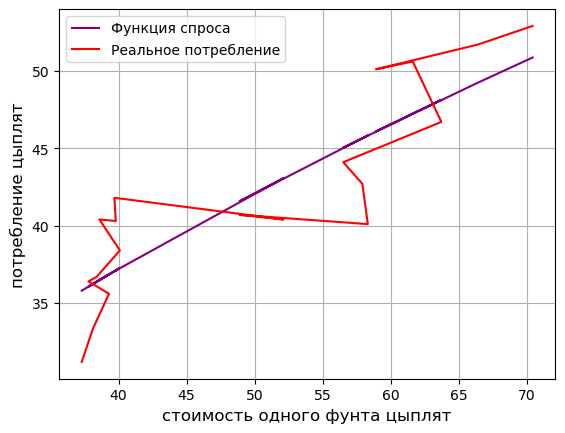

In [1221]:
plt.plot(data.X2, np.exp(model_1.fittedvalues), color='purple', label='Функция спроса')
plt.plot(data.X2, data.Y, color='red', label='Реальное потребление')
plt.xlabel('стоимость одного фунта цыплят', fontsize=12)
plt.ylabel('потребление цыплят', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

**Выводы:**

- Регрессия в целом значима на любом разумном уровне значимости

- Коэффициент $ b_2 $ значим на любом разумном уровне значимости

- При увеличении стоимости одного фунта цыплят на 1%, потребление цыплят в Великобритании увеличивается на 0.5527%

- Спрос неэластичен, так как коэффициент эластичности по модулю меньше 1

- Поведение людей нестандартно. При увеличении стоимости, обычно, потребление уменьшается, а в нашем случае - увеличивается. 

> Возможным объяснением этого может быть отсутствие в уравнении других важных регрессоров (к примеру, цен на товары заменители), так как их отсутствие может привести к смещению коэффициента $b_2$. Если между включенным и невключенным "важным" регрессором существует сильная положительная корреляция, коэффициент будет смещён вверх. Возможно, в данном случае он смещён вверх настолько, что стал положительным

- 72% общей вариативности логарифма потребления цыплят описывается логарифмом стоимости одного фунта цыплят

### *2. Функция потребления:*
>
> > $ \hat{Y} = b_0 * X_{1}^{b_1} $ 
> 
> Прологарифмирую:
>
> > $ ln(\hat{Y}) = ln(b_0) + b_1 * ln(X_1) $
>
> Замена:
>
> > - $ \tilde{\hat{Y}} = ln(\hat{Y}) $
> >
> > - $ \tilde{b_0} = ln(b_0) $ 
> >
> > - $ \tilde{X_1} = ln(X_1) $ 
>
> Тогда линейный вид уравнения:
>
> > $ \tilde{\hat{Y}} = \tilde{b_0} + b_1 * \tilde{X_1} $ 

In [1222]:
model_2 = smf.ols('ln_Y ~ ln_X1', data=ln_data).fit()

print(model_2.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.935    
Dependent Variable: ln_Y             AIC:                -68.6468 
Date:               2023-12-12 17:40 BIC:                -66.7579 
No. Observations:   19               Log-Likelihood:     36.323   
Df Model:           1                F-statistic:        259.8    
Df Residuals:       17               Prob (F-statistic): 9.84e-12 
R-squared:          0.939            Scale:              0.0014299
--------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept     1.7460     0.1229   14.2043   0.0000   1.4867   2.0053
ln_X1         0.2849     0.0177   16.1186   0.0000   0.2476   0.3222
------------------------------------------------------------------
Omnibus:              0.699         Durbin-Watson:           0.753
Pro

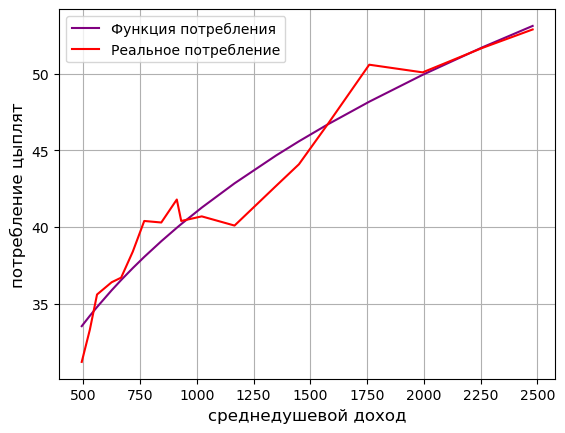

In [1223]:
plt.plot(data.X1, np.exp(model_2.fittedvalues), color='purple', label='Функция потребления')
plt.plot(data.X1, data.Y, color='red', label='Реальное потребление')
plt.xlabel('среднедушевой доход', fontsize=12)
plt.ylabel('потребление цыплят', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

**Выводы:**

- Регрессия в целом значима на любом разумном уровне значимости

- Коэффициент $ b_1 $ значим на любом разумном уровне значимости

- При увеличении среднедушевого дохода на 1%, потребление цыплят в Великобритании увеличивается на 0.2849%

- Потребление неэластично, так как коэффициент эластичности по модулю меньше 1

- Результаты логичны. При росте среднедушевого дохода потребление должно увеличиваться

- 93.5% общей вариативности логарифма потребления цыплят описывается логарифмом стоимости одного фунта цыплят, что выше, чем в модели спроса

### *3. Функция спроса-потребления:*
>
> > $ \hat{Y} = b_0 * X_{1}^{b_1} * X_{2}^{b_2} $
>
> Прологарифмирую:
>
> > $ ln(\hat{Y}) = ln(b_0) + b_1 * ln(X_1) + b_2 * ln(X_2)$
>
> Замена:
>
> > - $ \tilde{\hat{Y}} = ln(\hat{Y}) $
> >
> > - $ \tilde{b_0} = ln(b_0) $ 
> >
> > - $ \tilde{X_1} = ln(X_1) $ 
> >
> > - $ \tilde{X_2} = ln(X_2) $ 
>
> Тогда линейный вид уравнения:
>
> > $ \tilde{\hat{Y}} = \tilde{b_0} + b_1 * \tilde{X_1} + b_2 * \tilde{X_2}$ 

In [1224]:
model_3 = smf.ols('ln_Y ~ ln_X1 + ln_X2', data=ln_data).fit()

print(model_3.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.959     
Dependent Variable: ln_Y             AIC:                -76.7525  
Date:               2023-12-12 17:40 BIC:                -73.9192  
No. Observations:   19               Log-Likelihood:     41.376    
Df Model:           2                F-statistic:        213.7     
Df Residuals:       16               Prob (F-statistic): 2.87e-12  
R-squared:          0.964            Scale:              0.00089256
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
Intercept    2.0185     0.1267   15.9370   0.0000    1.7500    2.2870
ln_X1        0.4161     0.0416   10.0113   0.0000    0.3280    0.5043
ln_X2       -0.3048     0.0909   -3.3517   0.0041   -0.4976   -0.1120
------------------------------------------------------

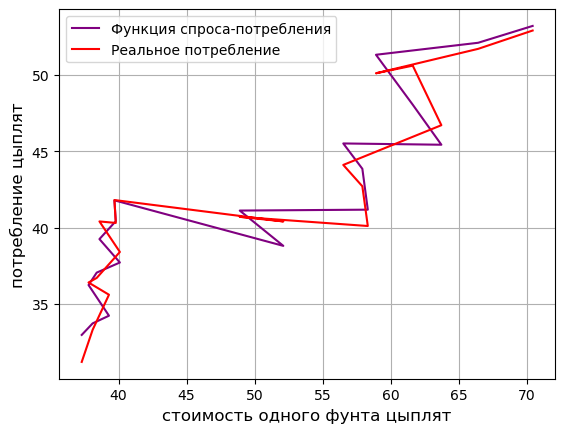

In [1225]:
plt.plot(data.X2, np.exp(model_3.fittedvalues), color='purple', label='Функция спроса-потребления')
plt.plot(data.X2, data.Y, color='red', label='Реальное потребление')
plt.xlabel('стоимость одного фунта цыплят', fontsize=12)
plt.ylabel('потребление цыплят', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

**Выводы:**

- Сама регрессия, как и все коэффициенты в ней - значима.

- При неизменной стоимости цыплят, при увеличении среднедушевого дохода на 1%, потребление цыплят увеличивается на 0.42%

- При неизменном среднедушевом доходе, при увеличении стоимости цыплят на 1%, потребление цыплят уменьшается на 0.3%

> Как только мы добавили в модель со стоимостью цыплят среднедушевой доход, коэффициент при стоимости цыплят стал ниже нуля. Это объясняется тем, что рост цены на цыплят в среднем сопровождается ростом среднедушевого дохода (присутствует положительная корреляция). Если этот среднедушевой доход не фиксировать, может получиться так, что при росте цен, среднедушевой доход увеличивается ещё сильнее, что приводит к увеличению потребления цыплят. Модель функции спроса, построенная ранее, говорит, что обычно так и происходит, так как коэффициент при стоимости цыплят в ней положительный.

- Эта модель описывает 0.964% изменений дисперсии исходного признака, что говорит о том, что эта модель на данный момент является самой эффективной

### *4. Функция спроса с учётом цены на товары-заменители:*
>
> > $ \hat{Y} = b_0 * X_{2}^{b_2} * X_{3}^{b_3} * X_{4}^{b_4} $
>
> Прологарифмирую:
>
> > $ ln(\hat{Y}) = ln(b_0) + b_2 * ln(X_2) + b_3 * ln(X_3) + b_4 * ln(X_4)$
>
> Замена:
>
> > - $ \tilde{\hat{Y}} = ln(\hat{Y}) $
> >
> > - $ \tilde{b_0} = ln(b_0) $ 
> >
> > - $ \tilde{X_2} = ln(X_2) $ 
> >
> > - $ \tilde{X_3} = ln(X_3) $ 
> >
> > - $ \tilde{X_4} = ln(X_4) $ 
>
> Тогда линейный вид уравнения:
>
> > $ \tilde{\hat{Y}} = \tilde{b_0} + b_2 * \tilde{X_2} + b_3 * \tilde{X_3} + b_4 * \tilde{X_4} $ 

In [1226]:
model_4 = smf.ols('ln_Y ~ ln_X2 + ln_X3 + ln_X4', data=ln_data).fit()

print(model_4.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.935    
Dependent Variable: ln_Y             AIC:                -67.1206 
Date:               2023-12-12 17:40 BIC:                -63.3429 
No. Observations:   19               Log-Likelihood:     37.560   
Df Model:           3                F-statistic:        87.74    
Df Residuals:       15               Prob (F-statistic): 9.73e-10 
R-squared:          0.946            Scale:              0.0014227
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept       2.3152    0.2215  10.4501  0.0000   1.8430   2.7874
ln_X2          -0.4875    0.2110  -2.3102  0.0355  -0.9372  -0.0377
ln_X3           0.2374    0.1556   1.5256  0.1479  -0.0943   0.5691
ln_X4           0.4601    0.0753   6.1120  0.0000   0.2996   0.6205
------

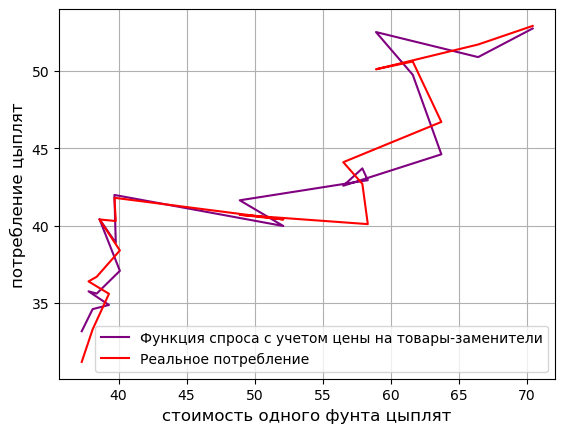

In [1227]:
plt.plot(data.X2, np.exp(model_4.fittedvalues), color='purple', label='Функция спроса с учетом цены на товары-заменители')
plt.plot(data.X2, data.Y, color='red', label='Реальное потребление')
plt.xlabel('стоимость одного фунта цыплят', fontsize=12)
plt.ylabel('потребление цыплят', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

**Выводы:**

- Модель в целом значима. Коэффициент при стоимости цыплят - значим на уровне значимости 5%, при стоимости свинины - не значим на уровне 5%, а коэффициент при стоимости говядины - значим на любом разумном уровне значимости

- Мы видим, что потребление цыплят, при прочих неизменных условиях, с изменением стоимости одного фунта на 1%, уменьшается на 0.48%, когда при увеличении стоимости свинины и говядины на 1% - растёт на 0.23% и 0.46% соответственно при прочих равных

> Также положительный коэффициент для функции спроса может объяснятся тем, что при повышении стоимости цыплят, цены на товары-заменители возрастают еще более значительно (присутствует сильная положительная корреляция). Это приводит к ситуации, когда с увеличением цен на цыплят их потребление не уменьшается, а, напротив, возрастает, так как они остаются относительно более дешевым выбором по сравнению с другими продуктами

- Доля объяснённой дисперсии для этой модели равна 0.93, что говорит о том, что потребление зависит больше от среднедушевого дохода, чем от стоимости товаров-заменителей (при том, что их цена тоже важна), так как для модели функции спроса-потребления $R^2_{adj}$ был выше

## **Тест Шапиро-Уилка:**

$H_0$ - данные нормально распределены

$H_1$ - данные распределены ненормально

In [1228]:
for var in data.drop(columns=['Y']).columns:
    print('p-value for', var, 'is', stats.shapiro(data[var])[1])

p-value for X1 is 0.04197002574801445
p-value for X2 is 0.008054640144109726
p-value for X3 is 0.04003702849149704
p-value for X4 is 0.01952611841261387


 На уровне значимости 5% ни одна из переменных не имеет нормального распределения 

## **Преобразование Бокса-Кокса:**

In [1229]:
data_boxcox = pd.DataFrame()
for var in data.drop(columns=['Y']).columns: 
    data_boxcox[var] = stats.boxcox(data[var])[0]

data_boxcox.head()

,X1,X2,X3,X4
0,2.795503,1.192043,2.523566,1.574717
1,2.806068,1.193245,2.578226,1.577477
2,2.814698,1.194966,2.610052,1.577668
3,2.830396,1.192800,2.590128,1.580898
4,2.839513,1.193684,2.582613,1.582304


## **Критерий Манна-Уитни:**

$H_0$ - выборки однородны

$H_1$ - выборки неоднородны

In [1230]:
stats.mannwhitneyu(data_boxcox.X2, data_boxcox.X3)

MannwhitneyuResult(statistic=0.0, pvalue=1.4798065133032065e-07)

Видно, что на любом разумном уровне значимости гипотеза об однородности выборок отклоняется. 

Это говорит о том, что распределение стоимостей одного фунта свинины образуется по другим законам относительно распределения стоимости одного фунта говядины

## **Критерий Флигнера-Клипера:**

$H_0$ - дисперсии двух выборок гомогенны

$H_1$ - дисперсии двух выборок отличны друг от друга

In [1231]:
stats.fligner(data_boxcox.X2, data_boxcox.X3)

FlignerResult(statistic=17.56785668435604, pvalue=2.7723506703585003e-05)

Различия в дисперсиях статистически значимы на любом разумном уровне значимости. Это говорит о том, что разброс стоимости одного фунта цыплят не равен разбросу стоимости одного фунта свинины

Так как критерий Стьюдента требует гомогенности дисперсий, воспользуюсь его модификацией - тестом Уэлча, который не требует предположения о равенстве диперсий между сравниваемыми группами 

$H_0$ - средняя стоимость одного фунта цыплят РАВНА средней стоимости одного фунта свинины

$H_1$ - средняя стоимость одного фунта цыплят НЕ РАВНА средней стоимости одного фунта свинины

In [1232]:
stats.ttest_ind(data_boxcox.X2, data_boxcox.X3, equal_var=False)

Ttest_indResult(statistic=-59.12265456715974, pvalue=2.1814249054774826e-22)

На любом разумном уровне значимости, гипотеза о равенстве средних двух групп отклоняется

In [1233]:
print(f'''
средняя стоимость одного фунта цыплят: {data.X2.mean()}, 
средняя стоимость одного фунта свинины: {data.X3.mean()}
''')


средняя стоимость одного фунта цыплят: 49.67368421052631, 
средняя стоимость одного фунта свинины: 98.27368421052631



Разница между этими средними СТАТИСТИЧЕСКИ ЗНАЧИМА. Можно сказать, что фунт свинины в среднем дороже фунта цыплят

# Задание 2
---

__`profitability`__ - прибыльность вложений в оборудование (%) 

__`staff`__ - среднее число сотрудников на один проект 

__`projects`__ - среднемесячное число проектов

__`adverts`__ - доля расходов на рекламу и продвижение своего бренда (%)

In [1234]:
data = pd.read_excel('задание2.xlsx')

data.head()

,staff,adverts,projects,profitability
0,8.768088,24.515827,8.499298,142.095390
1,9.129025,27.002612,7.414980,123.296482
2,8.269365,25.496132,6.524985,110.811052
3,9.838063,18.273113,5.211359,90.649576
4,10.382268,11.992892,7.973063,84.343632


In [1235]:
X, y = data.drop(columns=['profitability']), data.profitability

In [1236]:
def check_polynomial(X, y):
    """
    Функция для оценки полиномиальных регрессионных моделей различных степеней.

    Аргументы:
    X - DataFrame или массив независимых переменных.
    y - Серия или массив зависимой переменной.

    Возвращает:
    DataFrame с столбцами 'Степень полинома', 'r2', 'r2_adj', 'cross_val_rmse',
    содержащий результаты оценки для каждой степени полинома.
    """
    
    degree = []
    r2_list = []
    r2_adj_list = []
    cross_val_rmse_list = []

    i = 1
    while True:
        
        X_poly = PolynomialFeatures(degree=i, include_bias=False).fit_transform(X)

        n = X_poly.shape[0]
        k = X_poly.shape[1]

        model = LinearRegression().fit(X_poly, y)
        
        r2 = model.score(X_poly, y)
        r2_adj = 1 - (1 - r2) * (n - 1) / (n - k)
        cross_val_mse = -cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error').mean()

        degree.append(i)
        r2_list.append(r2)
        r2_adj_list.append(r2_adj)
        cross_val_rmse_list.append(np.sqrt(cross_val_mse))

        if k > n:
            break

        i += 1
    
    result = pd.DataFrame(
        {
            'Степень полинома': degree,
            'r2': r2_list,
            'r2_adj': r2_adj_list,
            'cross_val_rmse': cross_val_rmse_list
        }
    )

    return result

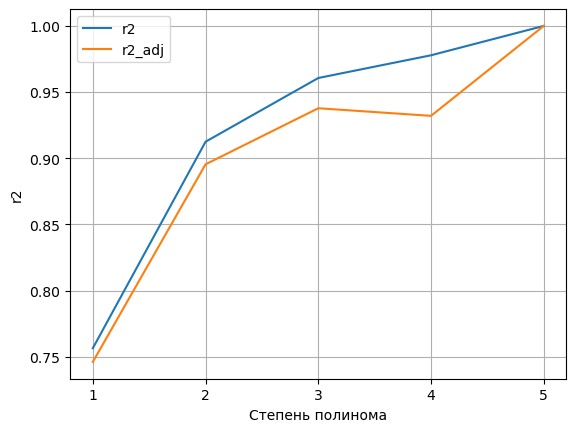

In [1237]:
cp = check_polynomial(X, y)

sns.lineplot(x=cp['Степень полинома'], y=cp['r2'], label='r2')
sns.lineplot(x=cp['Степень полинома'], y=cp['r2_adj'], label='r2_adj')
plt.xticks(cp['Степень полинома'])
plt.grid()

plt.show()

In [1238]:
# Выведу размерность данных при добавлении полиномиальных признаков в 5той степени
PolynomialFeatures(degree=5, include_bias=False).fit_transform(X).shape

(50, 55)

- Видим, что с увеличением степени полинома, стабильно увеличивается r^2, доходя до максимального значения в 1 на полиноме 5той степени. 
- Следует понимать, что при степени полинома равной 5, присутствует так называемая строгая мультиколлинеарность, так как ранг матрицы регрессоров меньше числа регрессоров. Эта модель в любом случае не будет адекватной 
- Исправленный r^2 принимает своё наивысшее значениее при степени полинома равной 3. При 4 степени появляются регрессоры, t-статистика коэффициентов (при проверке гипотезы на значимость) которых по модулю меньше 1 (при добавлении ко модели коэффициента, t-статистика которого по модулю меньше 1 приводит к уменьшению исправленного коэффициента детерминации). Это говорит о том, что в модели появляется больше незначимых признаков, чем значимых.
- В таком случае, самой рациональной моделью (игнорируя возможность переобучения) является модель с полиномом 3 степени

In [1239]:
cp[['Степень полинома', 'cross_val_rmse']].set_index('Степень полинома')

,cross_val_rmse
Степень полинома,
1,8.672230
2,8.051460
3,9.549975
4,86.086651
5,745.866638


Чтобы оценить модель с учётом переобучения, с помощью кросс-валидации были получены метрики RMSE для моделей с разными степенями полиномов. 

- При добавлении полиномиальных признаков второй степени, модель показывает результаты лучше, чем базовая модель (ошибка в среднем меньше на 0.6% прибыльности вложений в оборудование).

- Начиная со степени полинома равной трём, модель показывает результат всё хуже и хуже. Модель переобучается и на валидационных выборках показывает очень плохой результат (при строгой мультиколлинеарности модель ошибается на 745% прибыльности от вложений в оборудование). 

Нужно ли вообще менять спецификацию модели? Проведу RESET тест Рамсея

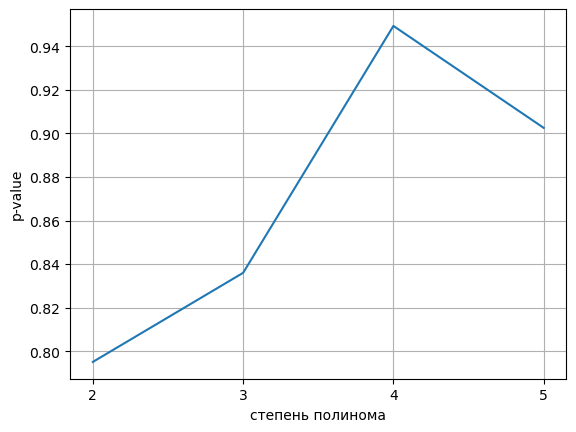

In [1240]:
model = smf.ols('profitability ~ staff + adverts + projects', data=data).fit()

p_values = []
for i in range(2, 6):
    p_values.append(linear_reset(model, use_f=True, power=i).pvalue)

plt.plot(range(2, 6), p_values)
plt.xlabel('степень полинома')
plt.xticks(range(2, 6))
plt.ylabel('p-value')
plt.grid()
plt.show()

Для всех доступных степеней полиномов, результаты теста говорят о том, что значимой информации в них нет (недостаточно оснований отклонить нулевую гипотезу). 

In [1241]:
get_poly = PolynomialFeatures(degree=2, include_bias=False)

X_poly_2 = pd.DataFrame(
    get_poly.fit_transform(X),
    columns=get_poly.get_feature_names_out()
)
model = sm.OLS(y, sm.add_constant(X_poly_2)).fit()

print(model.summary2())

                  Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.893   
Dependent Variable:   profitability    AIC:                318.4105
Date:                 2023-12-12 17:40 BIC:                337.5307
No. Observations:     50               Log-Likelihood:     -149.21 
Df Model:             9                F-statistic:        46.35   
Df Residuals:         40               Prob (F-statistic): 2.27e-18
R-squared:            0.913            Scale:              28.602  
-------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const            -99.1932  51.0638 -1.9425 0.0591 -202.3969  4.0105
staff             32.9042   6.9810  4.7134 0.0000   18.7952 47.0133
adverts            7.8510   2.6863  2.9226 0.0057    2.4218 13.2802
projects         -16.2264   6.8100 -2.3827 0.0220  -29.9899 -2.462

**Выводы:**

- Если мы берём за основу тест Рамсея и задача исследования состоит в основном в изучении предельных эффектов, правильнее будет не добавлять полиномиальные признаки вообще, так как они не несут значимой информации (исходя из теста Рамсея). 

- Если мы выбираем степень полинома через кросс-валидацию, то лучшим вариантом будет взять две степени, так как ошибка на валидационных выборках получилась минимальной именно с полиномом 2 степени.

- Анализируя результаты такой модели можно сделать выводы:
> - На уровне значимости 5% незначимыми коэффициентами являются коэффициенты МНК произведения регрессоров между собой. При этом коэффициенты квадратов регрессоров все получились значимо отличны от 0.  
> - Коэффициенты квадратов регрессоров могут объяснить различные эффекты от масштаба. К примеру, при увеличении "числа сотрудников на один проект" прибыльность увеличивается, но скорость увеличения прибыльности уменьшается, так как если в проекте слишком много сотрудников, их совокупная эффективность увеличивается всё медленее, а издержек на их содержание больше. Сотрудников может быть настолько много, что стоимость их содержания будет выше, нежели польза от их работы. Этот эффект и описывает отрицательный коэффициент для staff^2. Связь целевой переменной с projects скорее всего тоже нелинейна. Это связанно с тем, что с уменьшением числа проектов уменьшается прибыльность вложений в оборудование, но если проект был всего 1 или 2, то и издержек на их проведение было мало, что позволило получить всё ещё убыток от вложений в оборудование, но менее значительный

# Задание 3
---

In [1242]:
data = pd.read_excel('задание3.xlsx', header=2, index_col=0)

data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
id,,,,,,,,,,,,,,
96,0,60.96,2.68,186.81,0.67,4.02,45.11,5.93,0.67,705.98,0,42.02,2.68,100.00
97,0,55.02,7.42,11.34,2.18,4.36,89.58,3.29,1.31,568.75,2,29.96,4.72,100.00
99,0,69.08,51.50,56.98,23.53,28.41,129.33,16.78,9.92,806.07,18,29.21,11.24,41.70
101,0,53.54,64.43,59.06,1.34,2.68,86.71,9.09,2.68,675.82,0,21.33,8.51,32.17
103,0,61.61,56.86,96.73,19.57,20.31,88.33,13.87,1.85,705.08,6,18.79,3.14,74.96


**Стандартизирую данные:**

In [1243]:
data_scaled = StandardScaler().fit_transform(data)

**Найду число компонент, описывающее 75% изменения дисперсии:**

In [1244]:
pca = PCA().fit(data_scaled)

explained_variance = pca.explained_variance_ratio_

explained_variance = np.insert(explained_variance, 0, 0)

opt_n_components = np.argmax((np.cumsum(explained_variance) > 0.75))

print(f'Число компонент, описывающее 75% изменения дисперсии = {opt_n_components}')

Число компонент, описывающее 75% изменения дисперсии = 5


**Продемонстрирую это на графике:**

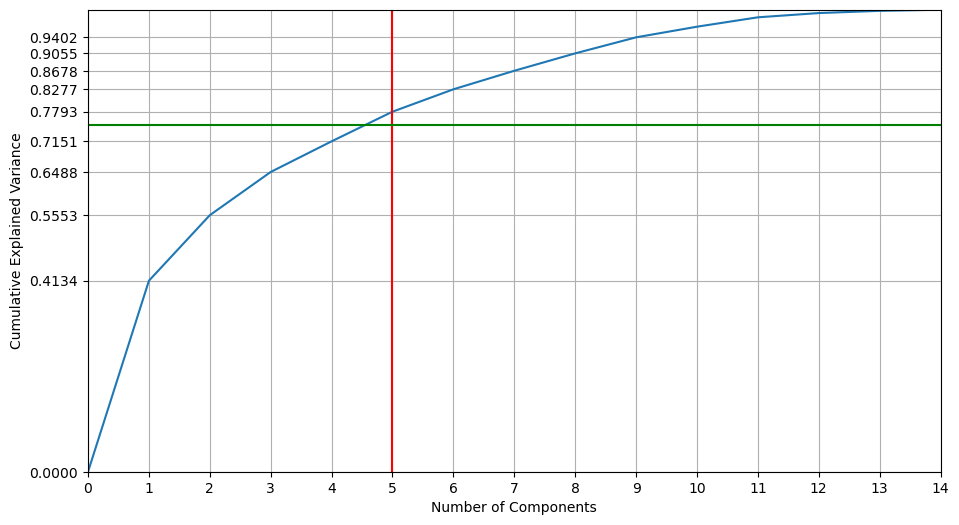

In [1245]:
plt.figure(figsize=(11, 6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.xticks(range(len(explained_variance)))
plt.yticks(np.cumsum(explained_variance)[:10])
plt.axvline(opt_n_components, c='red', label='Оптимальное количество главных компонент')
plt.axhline(0.75, c='green')
plt.ylim(0, 1)
plt.xlim(0, len(explained_variance)-1)
plt.show()

**Получу каждую линейную комбинацию регрессоров, составляющую каждую главную компоненту соответственно:**

In [1246]:
pca = PCA(n_components=opt_n_components).fit(data_scaled)

pca_wheights = pd.DataFrame(
    pca.components_, 
    index=pca.get_feature_names_out(), 
    columns=data.columns
)

pca_wheights.T

,pca0,pca1,pca2,pca3,pca4
x1,0.286077,-0.024815,0.006826,-0.394031,-0.281518
x2,0.130998,-0.286017,-0.552065,0.089233,-0.258878
x3,0.341195,0.220335,-0.067550,0.257806,0.314041
x4,0.328794,0.207432,-0.083680,0.195291,0.339940
x5,0.377938,0.109494,-0.071680,0.065173,0.059975
x6,0.384608,0.084955,-0.037909,0.002735,0.071934
x7,0.321761,-0.136513,0.193202,-0.383670,0.111599
x8,0.202066,-0.160758,0.355389,0.073756,-0.512340
x9,0.155014,0.161343,0.346103,0.514355,-0.402571
x10,0.182643,-0.498700,-0.209975,0.023377,0.092271


# Задание 4
---

In [1247]:
data = pd.read_excel('задание4.xls')

data.head()

,target,age,educ,work_exp,interest,coffee,boss_educ,passport,green,floor,children,climate,offhour,dist,salary,heigh,lunch
0,0,50,4,27,8,1.3,1,0,2,3,2,0,0,10.6,1,176,226
1,0,30,3,10,0,0.0,6,1,2,3,0,0,0,11.5,0,186,226
2,0,43,3,22,7,1.9,6,1,1,5,0,3,0,12.8,1,166,238
3,0,58,3,31,7,2.0,4,0,3,3,1,1,0,15.2,1,180,216
4,1,40,3,23,7,0.0,6,1,3,2,0,0,0,16.1,1,180,286


__`target`__ – сотрудник уволится в следующем году (0-нет, 1-да)

__`age`__ - возраст

__`educ`__ - образование (1-начальное, 2-среднее, 3 -неоконченное высшее, 4-два и более высших образования, 5-кандидат наук, 6-доктор наук)

__`work_exp`__ – стаж работы (лет)

__`interest`__ – оценка сотрудником интереса к работе (от 0 до 10)

__`coffee`__ - среднее количество чашек кофе, выпиваемых сотрудником за рабочий день

__`boss_educ`__ - образование руководителя (1-начальное, 2-среднее, 3 -неоконченное высшее, 4-два и более высших образования, 5-кандидат наук, 6-доктор наук)

__`passport`__ - наличие загранпаспорта у сотрудника (1-есть, 0 -нет)

__`green`__ - степень озеленения офиса (от 1 до 5)

__`floor`__ – этаж работы

__`children`__ – количество детей у сотрудника

__`climate`__ - удовлетворенность рабочей атмосферой (от 0 до 4)

__`offhour`__ – наличие переработок (1-да, 0 -нет)

__`dist`__ – расстояние до работы

__`salary`__ – удовлетворенность заработной платой (1-да, 0 -нет)

__`height`__ - рост сотрудника

__`lunch`__ - средняя цена бизнес-ланча в офисе

In [1248]:
X, y = data.drop('target', axis=1), data.target

**Посмотрю на баланс классов:**

In [1249]:
y.value_counts(normalize=True)

0    0.679878
1    0.320122
Name: target, dtype: float64

Видно, что классы несбалансированны. Для оценки модели правильнее будет использование не accuracy, а других метрик. 

В практическом смысле важнее всего будет метрика полноты (recall), так как, обычно, не важно точно определять, уволится ли человек с работы. Целью является определить людей, которые потенциально могут уволиться, чтобы провести с ними работу. В таком случае более важно, чтобы как можно больше потенциальных увольнений было предсказанно, чем то, с какой точностью эти люди на самом деле уволятся.

**Посмотрю корреляции между признаками:**

<Axes: >

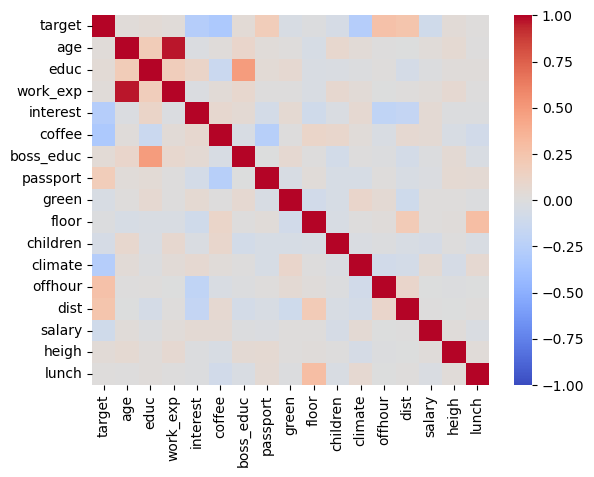

In [1250]:
sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='coolwarm')

Видна большая корреляция только у перемнных "стаж работы" и "возраст", остальные же корреляции не принимают больших значений

**Использую инструмент RFECV для удаления признаков:**

In [1251]:
model = LogisticRegression()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='recall')

rfecv.fit(X, y)

print(f'''
Оптимальное количество признаков: {rfecv.n_features_}
Удалённые из модели признаки: {set(rfecv.feature_names_in_) - set(rfecv.get_feature_names_out())}
''')


Оптимальное количество признаков: 13
Удалённые из модели признаки: {'heigh', 'lunch', 'age'}



RFECV (Recursive Feature Elimination with Cross-Validation) был использован для последовательного удаления признаков из модели. В процессе этого метода осуществляется оценка recall через кросс-валидацию, что позволяет определить, какие признаки следует исключить для оптимизации модели.

- По резуьтатам моделирования были удалены признаки:
> - Рост сотрудника. Исходя из логических суждений, рост сотрудников никак не влияет на текучесть кадров
> - Средняя цена бизнес ланча в офисе. 
> - Возраст сотрудника. Удалена, скорее всего, потому что эта переменная коррелированна со стажем работы, и для правильного анализа и интерпретации достаточно одной из этих двух переменных.

**Удалю признаки, выбранные моделью в прошлом пункте и построю модель без них:**

In [1252]:
X = X[rfecv.get_feature_names_out()]

model = sm.Logit(y, sm.add_constant(X)).fit()

print(pd.concat([model.params.round(2), model.pvalues.round(2)], axis=1, keys=['coef', 'p-value']))

Optimization terminated successfully.
         Current function value: 0.438384
         Iterations 7
           coef  p-value
const     -1.30     0.01
educ       0.01     0.91
work_exp   0.01     0.20
interest  -0.16     0.00
coffee    -0.93     0.00
boss_educ  0.11     0.10
passport   0.59     0.00
green      0.02     0.77
floor     -0.04     0.05
children  -0.11     0.10
climate   -0.51     0.00
offhour    1.17     0.00
dist       0.14     0.00
salary    -0.39     0.02


Видны незначимые переменные, p-value для теста на равенство нулю коэффициента которых настолько велик, что эти переменные также можно исключить из модели:

- Образование

- Степень озеленения офиса

**Построю модель с удалёнными незначимыми признаками:**

In [1253]:
X = X.drop(['educ', 'green'], axis=1)

model = sm.Logit(y, sm.add_constant(X)).fit()

print(pd.concat([model.params.round(2), model.pvalues.round(2)], axis=1, keys=['coef', 'p-value']))

Optimization terminated successfully.
         Current function value: 0.438435
         Iterations 7
           coef  p-value
const     -1.24     0.01
work_exp   0.01     0.18
interest  -0.16     0.00
coffee    -0.93     0.00
boss_educ  0.11     0.05
passport   0.59     0.00
floor     -0.04     0.05
children  -0.11     0.10
climate   -0.50     0.00
offhour    1.17     0.00
dist       0.14     0.00
salary    -0.39     0.02


Если брать уровень значимости, равный 5%, то незначимыми получаются переменные со стажем работы и количеством детей. Исходя из логических соображений, я бы хотел оставить эти переменные в итоговой модели.  

Суждения:
- При увеличении стажа работы на каждый год шанс увольнения слегка увеличивается. Это может указывать на то, что сотрудники с большим опытом могут искать новые возможности или сталкиваться с изменениями в карьерных амбициях.
- При увеличении детей, у сотрудников увеличивается потребность в стабильности, что говорит о меньшей вероятности увольнения.

**Интерпретация коэффициентов выбранной модели:**

- **interest**: Увеличение интереса к работе на один балл значительно снижает шанс увольнения. Это говорит о том, что мотивированные и заинтересованные сотрудники менее склонны к уходу.

- **coffee**: Если сотрудник выпивает на одну чашку кофе больше в день, его шанс увольнения сокращается почти вдвое. Это может быть связано с культурой работы и перерывами на кофе, способствующими социальному взаимодействию и удовлетворённости работой.

- **boss_educ**: Чем выше уровень образования у руководителя, тем немного больше шанс увольнения сотрудника. Возможно, это связано с ожиданиями сотрудников или стилем управления высокообразованных руководителей. Также это может быть связанно с тем, что если руководитель образован, то вероятность того, что сотрудник может занять его место - ниже.

- **passport**: Сотрудники, имеющие загранпаспорт, имеют больший шанс увольнения, что может отражать их более высокую мобильность и доступ к международным возможностям.

- **floor**: Шанс увольнения уменьшается с каждым этажом, на котором работает сотрудник. Это может быть связано с физическим местоположением в компании или с тем, что более высокие этажи могут быть признаком высшего статуса внутри компании.

- **climate**: Удовлетворенность рабочей атмосферой сильно влияет на снижение шанса увольнения. Положительный климат в офисе важен для удержания сотрудников.

- **offhour**: Сотрудники, которые часто работают сверхурочно, гораздо более склонны к увольнению, что может указывать на проблемы с балансом работы и личной жизни.

- **dist**: Большее расстояние до работы увеличивает вероятность увольнения, вероятно, из-за увеличенной нагрузки от долгих поездок и стресса.

- **salary**: Недовольство заработной платой значительно увеличивает шанс увольнения, подчеркивая важность финансового удовлетворения для удержания сотрудников.


**Построю матрицу ошибок для этой модели:**

In [1254]:
model = LogisticRegression()

model.fit(X, y)

y_pred = model.predict(X)
y_pred_proba = model.predict_proba(X)[:, 1]

print(confusion_matrix(y, y_pred))

[[577  92]
 [135 180]]


**Найду различные метрики качества через кросс-валидацию:**

In [1255]:
metrix = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

results = []
for i in metrix:
    result = cross_val_score(model, X, y, cv=StratifiedKFold(5), scoring=i).mean()
    results.append(result)

pd.DataFrame(results, index=metrix, columns=['cross_val_score'])

,cross_val_score
accuracy,0.763203
f1,0.603268
precision,0.652225
recall,0.561905
roc_auc,0.837182


Видно, что резултаты логистической регрессии, оценённые через кросс-валидацию, не оставляют желать лучшего. Так как только 56% уволившихся модель предсказывает. При этом доля вернях ответов составляет 76%

**Построение ROC-кривой:**

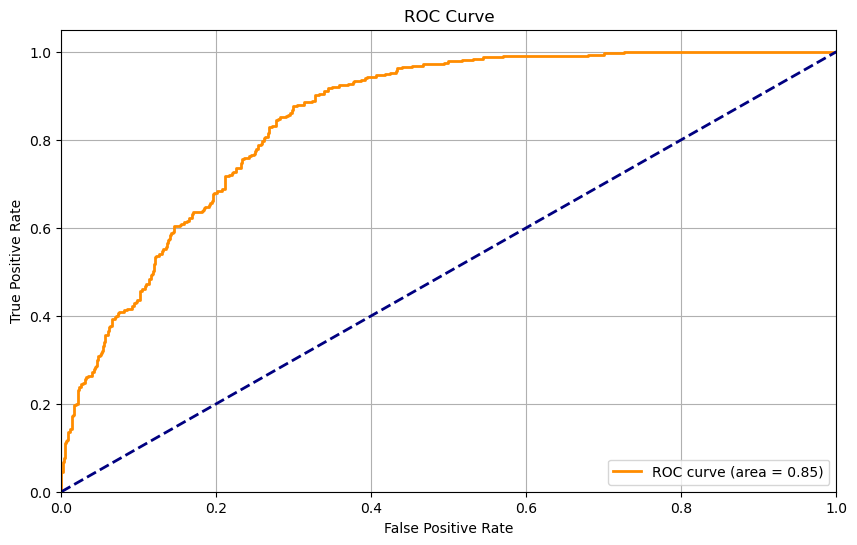

In [1256]:
fpr, tpr, threshold = roc_curve(y, y_pred_proba)
auc = roc_auc_score(y, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

В целом, ROC-кривая показывает, что модель имеет право на существование и показывает результаты значительно лучше, чем случайное угадывание